## Import

In [1]:
import pandas as pd
import numpy as np

In [2]:
DATE_TIME_COLUMNS = ['DATETIME_INI', 'DATETIME_FIM']

# Load the data
dataset = pd.read_csv('../../../data/dataset.csv', index_col='PES_ID', parse_dates=DATE_TIME_COLUMNS)

## Required Preprocessing

In [3]:
import time

dataset["DATETIME_INI"] = dataset["DATETIME_INI"].apply(lambda x: time.mktime(x.timetuple()))
dataset["DATETIME_FIM"] = dataset["DATETIME_FIM"].apply(lambda x: time.mktime(x.timetuple()))

In [4]:
dataset['LOCDESCARREGO_DESC'] = dataset['LOCDESCARREGO_DESC'].astype('category')
dataset['EMP_NOME'] = dataset['EMP_NOME'].astype('category')
dataset['ROTA_ID'] = dataset['ROTA_ID'].astype('category')
dataset['TPVEICULO_DESC'] = dataset['TPVEICULO_DESC'].astype('category')
dataset['COLETA_DESC'] = dataset['COLETA_DESC'].astype('category')
dataset['ESPECCOLETA_DESC'] = dataset['COLETA_DESC'].astype('category')
dataset['ROTA_DESC'] = dataset['ROTA_DESC'].astype('category')
dataset['TPCIRCUITO_DESC'] = dataset['TPCIRCUITO_DESC'].astype('category')
dataset['LOCAL_NOME'] = dataset['LOCAL_NOME'].astype('category')

## Training

In [5]:
target_column_name = 'PES_PESOUTIL'
target_column = dataset.pop(target_column_name)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset, target_column, test_size=0.3, random_state=42)

In [7]:
import xgboost as xg

xgr = xg.XGBRegressor(objective ='reg:squarederror',
                      tree_method = 'hist', 
                      learning_rate = 0.2,
                      max_depth = 5,
                      alpha = 400,
                      n_estimators = 500,
                      enable_categorical = True
                      )
xgr.fit(X_train, y_train)

XGBRegressor(alpha=400, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, ...)

In [8]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, xgr.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 16793.2434


### Parameterizing

In [9]:
# from sklearn.model_selection import GridSearchCV
# # set up our search grid
# param_grid = {"max_depth":    [5],
#               "tree_method":  ["hist"],
#               "n_estimators": [500, 600],
#               "learning_rate": [0.2],
#               "alpha": [400, 500]}

# xgr = xg.XGBRegressor(objective ='reg:squarederror')

# # try out every combination of the above values
# search = GridSearchCV(xgr, param_grid, cv=10).fit(X_train, y_train)

# print("The best hyperparameters are ",search.best_params_)

## Cross-Validation

In [10]:
import random
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit

def cross_validate_model(model, X, y, cv=10):
    cv = ShuffleSplit(n_splits=cv, test_size=0.3, random_state=random.randint(0, 1000))
    scores = cross_validate(estimator=model,
                            X=X,
                            y=y,
                            cv=cv,
                            scoring=('r2', 'neg_mean_squared_error', 'neg_root_mean_squared_error'),
                            return_train_score=True
                            )
    return scores

## Experimentation

In [11]:
import time

N_ITERATIONS = 5
N_CROSS_VALIDATION = 10

scores = []
duration = []

for _ in range(N_ITERATIONS):
    time_start = time.time()
    scores.append(cross_validate_model(xgr, dataset, target_column, cv=N_CROSS_VALIDATION))
    duration.append(time.time() - time_start)

### Training Duration

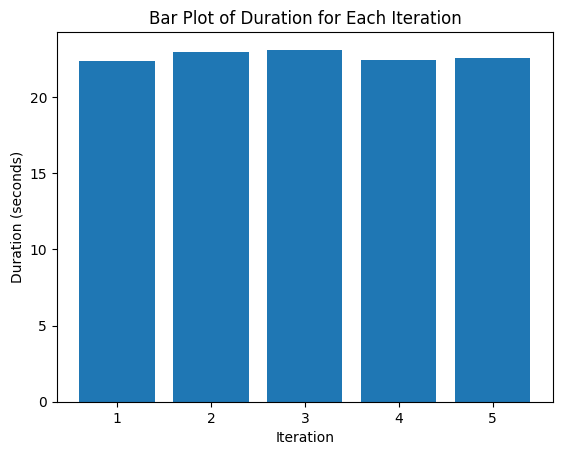

Training time: 22.68850016593933 ± 0.2871131720529756 seconds


In [12]:
import matplotlib.pyplot as plt

# Create a bar plot
plt.bar(range(1,len(duration)+1), duration)
plt.xlabel('Iteration')
plt.ylabel('Duration (seconds)')
plt.title('Bar Plot of Duration for Each Iteration')
plt.show()

time_training = np.mean(duration)
time_training_std = np.std(duration)

print(f"Training time: {time_training} ± {time_training_std} seconds")

### R2 Score

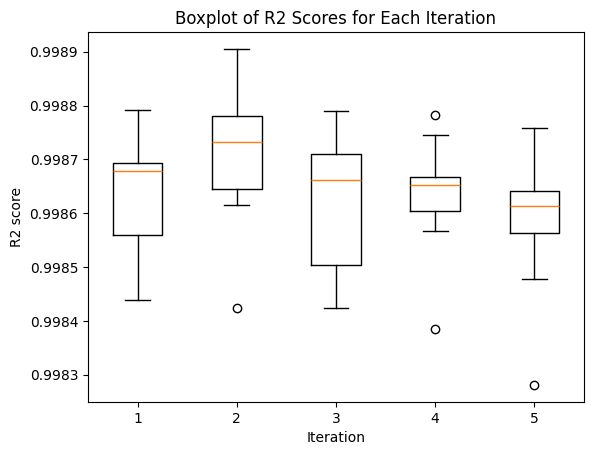

Mean R2 score: 0.9986
Standard deviation of R2 scores: 0.0001


In [13]:
import matplotlib.pyplot as plt

r2_scores = [r2['test_r2'] for r2 in scores]

# Create a boxplot of the R2 scores for each iteration
plt.boxplot(r2_scores)
plt.xlabel('Iteration')
plt.ylabel('R2 score')
plt.title('Boxplot of R2 Scores for Each Iteration')
plt.show()

# Calculate the mean and standard deviation of the R2 scores
r2_scores_mean = np.mean(r2_scores)
r2_scores_std = np.std(r2_scores)

print(f"Mean R2 score: {r2_scores_mean:.4f}")
print(f"Standard deviation of R2 scores: {r2_scores_std:.4f}")

### MSE

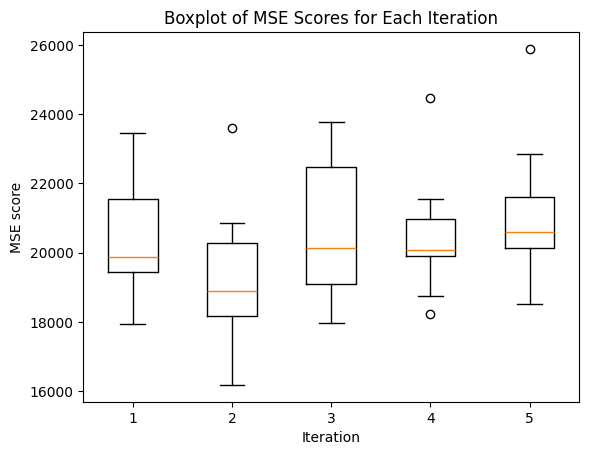

Mean MSE: 20372.4414
Standard Deviation of MSE: 1986.8731


In [14]:
# Calculate MSE for each fold
mse_scores = [-mse['test_neg_mean_squared_error'] for mse in scores]
plt.boxplot(mse_scores)
plt.xlabel('Iteration')
plt.ylabel('MSE score')
plt.title('Boxplot of MSE Scores for Each Iteration')
plt.show()

# Calculate mean and standard deviation of MSE scores
mean_mse = np.mean([mse.mean() for mse in mse_scores])
std_mse = np.std(mse_scores)

print("Mean MSE: {:.4f}".format(mean_mse))
print("Standard Deviation of MSE: {:.4f}".format(std_mse))

### RMSE

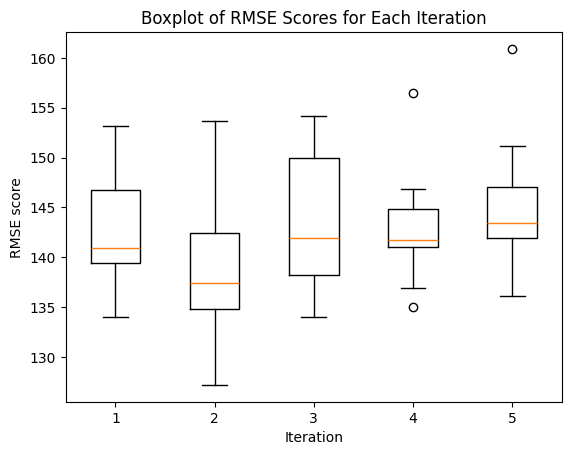

Mean RMSE: 142.5652
Standard Deviation of RMSE: 6.8991


In [15]:
rmse_scores = [-rmse['test_neg_root_mean_squared_error'] for rmse in scores]

# Plot the RMSE scores
plt.boxplot(rmse_scores)
plt.xlabel('Iteration')
plt.ylabel('RMSE score')
plt.title('Boxplot of RMSE Scores for Each Iteration')
plt.show()

# Calculate mean and standard deviation of RMSE scores
mean_rmse = np.mean([rmse.mean() for rmse in rmse_scores])
std_rmse = np.std(rmse_scores)

print("Mean RMSE: {:.4f}".format(mean_rmse))
print("Standard Deviation of RMSE: {:.4f}".format(std_rmse))

## Exporting Metrics

In [16]:
import os

# Define the filename for the metrics dataset
metrics_filename = "../results.csv"

# Check if the metrics.csv file exists
if os.path.exists(metrics_filename):
    # Load the metrics dataset
    metrics_dataset = pd.read_csv(metrics_filename, index_col='Algorithm')
    
    data = {
        "Mean R2 score": r2_scores_mean,
        "Standard deviation of R2 scores": r2_scores_std,
        "Mean MSE": mean_mse,
        "Standard deviation of MSE": std_mse,
        "Mean RMSE": mean_rmse,
        "Standard deviation of RMSE": std_rmse,
        "Mean Training time": time_training,
        "Standard deviation of Training time": time_training_std
    }
    
    df = pd.DataFrame(data, index=['XGBoostRegressor_raw'])
    
    metrics_dataset = pd.concat([metrics_dataset, df], axis=0)
    
    # Save the updated metrics dataset
    metrics_dataset.to_csv(metrics_filename, index=True, index_label='Algorithm')
else:
    # The metrics.csv file does not exist, print an error message
    print("The metrics.csv file does not exist.")
